In [22]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from lib.layers import LinOSSModel
from lib.dataset import PDEDataset
from lib.utils import relative_l2_error

In [23]:
sns.set_context("paper")
sns.set_style("whitegrid")

In [24]:
torch.manual_seed(0)
np.random.seed(0)

In [25]:
N_TRAIN = 64 # number of training samples
BATCH_SIZE = 64
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
training_data = PDEDataset("data/train_sol.npy", device=DEVICE)
# choose N_TRAIN samples randomly
val_data, train_data = torch.utils.data.random_split(training_data, [N_TRAIN, len(training_data) - N_TRAIN])

In [27]:
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

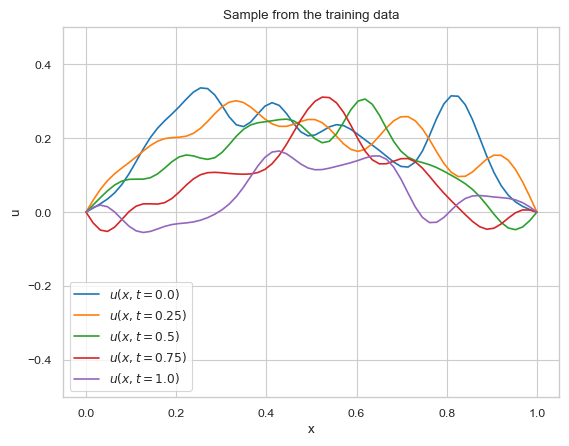

In [28]:
# plot a random sample from the training data
sample = training_data.data[np.random.randint(0, len(train_data))]
for t in range(len(sample)):
    plt.plot(
        sample[t, :, 1].cpu().numpy(),
        sample[t, :, 0].cpu().numpy(), label=f'$u(x, t={t / 4})$')

plt.ylim(-0.5, 0.5)
plt.xlabel("x")
plt.ylabel("u")
plt.title("Sample from the training data")
plt.legend()

In [ ]:
learning_rate = 0.001
epochs = 10000
step_size = 500
gamma = 0.75

In [ ]:
model = LinOSSModel(
    input_dim=64,
    output_dim=64,
    hidden_dim=256,
    num_layers=3,
).to(DEVICE)

In [31]:
dt = 1

In [32]:
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, "min", patience=step_size
# )
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=step_size, eta_min=1e-6
)

In [33]:
model.train()

metrics = {
    "training_loss": [],
    "validation_loss": [],
    "lr": [],
}

progress_bar = tqdm.tqdm(range(epochs))
for epoch in progress_bar:
    train_loss = 0.0
    for input, target in train_data_loader:
        optimizer.zero_grad()

        input = input[..., 0]
        prediction = model(input, dt).squeeze(-1)

        # integrate over time to get the final prediction (sum)
        prediction = torch.cumsum(prediction, dim=-1)

        loss = relative_l2_error(prediction, target[..., 1:, :], dim=None)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_data_loader)

    # Compute validation loss
    validation_relative_l2 = 0.0
    for input, target in val_data_loader:
        input = input[..., 0]

        with torch.no_grad():
            prediction = model(input, dt).squeeze(-1)

        prediction = torch.cumsum(prediction, dim=-1)

        loss = relative_l2_error(prediction, target[..., 1:, :], dim=None)
        validation_relative_l2 += loss.item()

    validation_relative_l2 /= len(val_data_loader)

    metrics["training_loss"].append(train_loss)
    metrics["lr"].append(scheduler.get_last_lr())
    metrics["validation_loss"].append(validation_relative_l2)

    scheduler.step()

    progress_bar.set_postfix(
        {
            "train_loss": train_loss,
            "val_loss": validation_relative_l2,
        }
    )


100%|██████████| 1000/1000 [01:02<00:00, 15.95it/s, train_loss=0.0552, val_loss=0.0602]


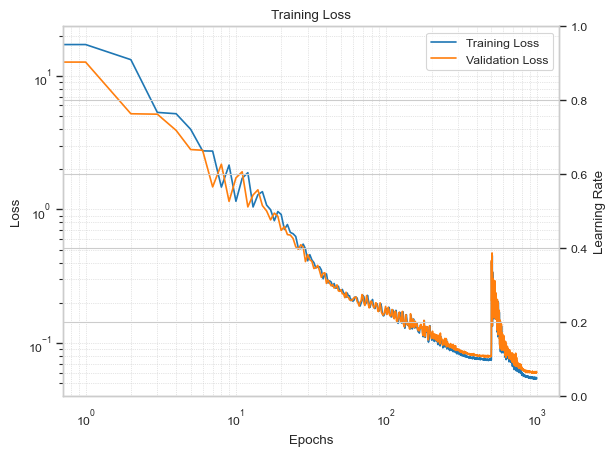

In [34]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

l1 = ax1.loglog(metrics["training_loss"], label="Training Loss")
l2 = ax1.loglog(metrics["validation_loss"], label="Validation Loss")
#l3 = ax2.plot(metrics["lr"], label="Learning Rate", color="green", linestyle="--", linewidth=0.5)

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Learning Rate")
plt.title("Training Loss")

plt.legend(l1 + l2, [l.get_label() for l in l1 + l2])
ax1.grid(True, which="both", ls=":", linewidth=0.5)
plt.show()

In [35]:
test_data = PDEDataset("data/test_sol.npy", device=DEVICE)
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [36]:
model.eval()
progress_bar = tqdm.tqdm(test_data_loader)

with torch.no_grad():
    test_relative_l2 = 0.0
    for input, target in progress_bar:
        input = input[..., 0]
        target = target[..., 1:, :]
        prediction = model(input, dt).squeeze(-1)
        prediction = torch.cumsum(prediction, dim=-1)

        loss = torch.sum(relative_l2_error(prediction, target, dim=None))
        test_relative_l2 += loss.item()
    test_relative_l2 /= len(test_data)

test_relative_l2

100%|██████████| 2/2 [00:00<00:00, 24.92it/s]


0.0008446554420515895

In [37]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 2692688


In [ ]:
# save model to disk
torch.save(model.state_dict(), "models/linOSS_model.pth")

In [39]:
test_data = PDEDataset("data/test_sol.npy")
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [40]:
# pick 10 random samples and draw prediction and target
samples = DataLoader(test_data, batch_size=4, shuffle=True)

torch.Size([4, 4, 64, 2]) torch.Size([4, 5, 64])
torch.Size([4, 4, 64]) torch.Size([4, 4, 64])
torch.Size([4, 4, 64, 2]) torch.Size([4, 5, 64])
torch.Size([4, 4, 64]) torch.Size([4, 4, 64])
torch.Size([4, 4, 64, 2]) torch.Size([4, 5, 64])
torch.Size([4, 4, 64]) torch.Size([4, 4, 64])
torch.Size([4, 4, 64, 2]) torch.Size([4, 5, 64])
torch.Size([4, 4, 64]) torch.Size([4, 4, 64])


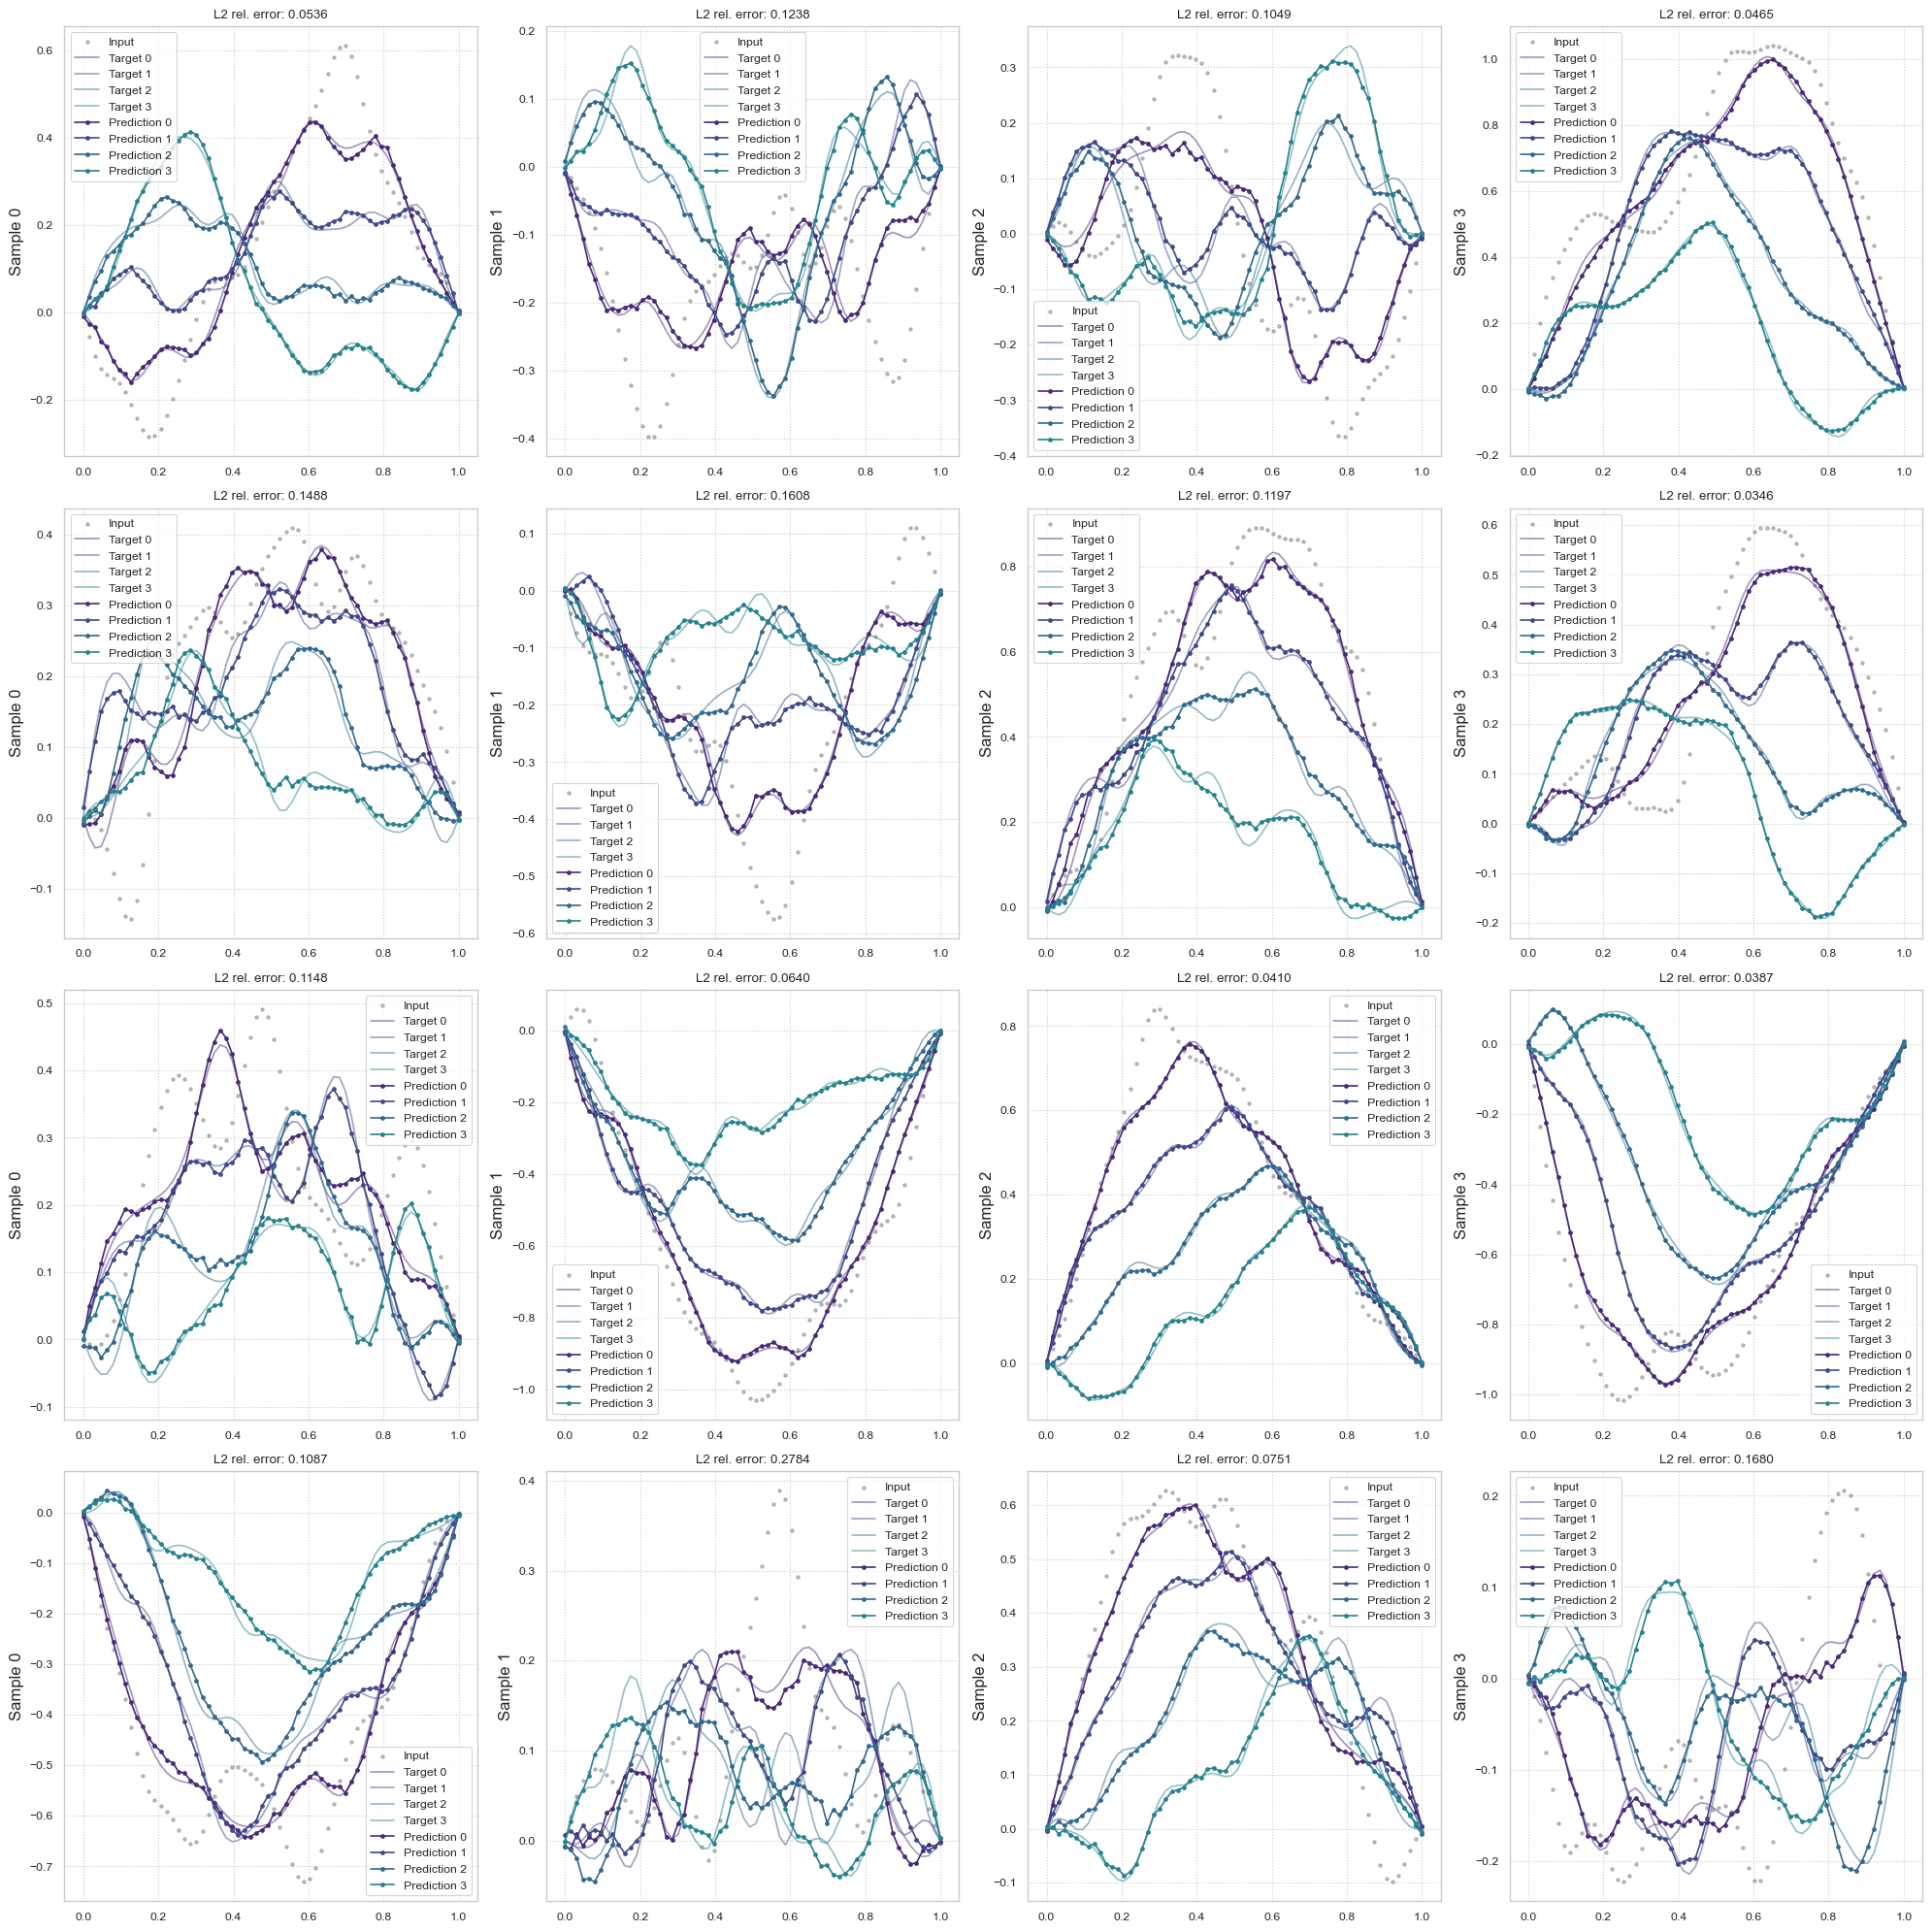

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

model.eval()
with torch.no_grad():
    for i, (ax_rows, sample) in enumerate(zip(axs, samples)):
        input_o, target = sample

        print(input_o.shape, target.shape)

        input = input_o[..., 0]
        target = target[..., 1:, :]

        prediction = model(input, dt).squeeze(-1)
        prediction = torch.cumsum(prediction, dim=-1)

        print(prediction.shape, target.shape)

        for j, (p, t, init) in enumerate( zip(prediction, target, input_o)):
            
            re_l2_error = relative_l2_error(p[-1], t[-1]).item()
            # print(f"Sample {j} L2 rel. error: {re_l2_error:.4f}")
            ax = ax_rows[j]

            ax.set_ylabel(f"Sample {j}", fontsize=12)

            x_grid = init.numpy()[0, :, 1]
            initial = init.numpy()[0, :, 0]

            ax.scatter(
                x_grid,
                initial,
                label="Input",
                alpha=0.5,
                color="gray",
                marker=".",
            )

            colors = sns.color_palette("viridis", n_colors=len(t) + len(p))

            plot_last_only = False

            for k, tar in enumerate(t):
                if plot_last_only:
                    if k != len(t) - 1:
                        continue
                ax.plot(
                    x_grid,
                    tar.numpy(),
                    label=f"Target {k}",
                    color=colors[k],
                    alpha=0.5,
                )

            for k, pre in enumerate(p):
                if plot_last_only:
                    if k != len(p) - 1:
                        continue
                ax.plot(
                    x_grid,
                    pre.numpy(),
                    label=f"Prediction {k}",
                    color=colors[k],
                    marker=".",
                )

            ax.set_title(f"L2 rel. error: {re_l2_error:.4f}")

            ax.legend()
            ax.grid(True, which="both", ls=":")


plt.tight_layout()
plt.savefig("figures/LinOSS_test_examples.png", dpi=300)